## Credits
https://github.com/pytorch/tutorials


**EfficientNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

**Finetuning the EfficientNet:** Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on ImageNet 1000 dataset. Rest of the training looks as usual.

## Requirements

In [1]:
# Requirements
! [ ! -z "$COLAB_GPU" ] && pip install ipython-autotime pandas --upgrade pandas torch efficientnet-pytorch --upgrade efficientnet-pytorch
%load_ext autotime
import torch
torch.manual_seed(42) # We have to set a manual seed for results to be reproducible

Requirement already up-to-date: ipython-autotime in /usr/local/lib/python3.6/dist-packages (0.1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.1)
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: efficientnet-pytorch in /usr/local/lib/python3.6/dist-packages (0.6.1)


## Functions

In [2]:
# Functions

import torchvision
from torch.utils.data import DataLoader,Dataset
from PIL import Image

# Custom Pytorch dataloader for this dataset
class Derm(Dataset):
    """Reads a pandas dataframe with the images paths
    and labels"""
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['lesion_code'][index]))
        
        if self.transform:
            X = self.transform(X)

        return X, y

# Image shower
def imshow(img):
    """Plots 4 images in a small grid"""
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

time: 104 ms


## Preprocessing

In [3]:
# Upload your folder with skin and not skin images to google drive with this structure:
# ~/dataset:
#    /skin:
#       image1
#       image2
#      ..
#    /not_skin
#       image1
#       image2
#      ..

# Mount google drive to access your folder
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
time: 20.6 s


In [4]:
# Go to your drive folder
% cd './drive/My Drive/'
# Check what folders are in your drive
% ls

/content/drive/My Drive
'Colab Notebooks'/   dataset/   test_net.pth
time: 3.81 s


In [5]:
# Specify the folder that contains your images
data_dir = '/content/drive/My Drive/dataset'

time: 2.45 ms


In [6]:
import pandas as pd
import numpy as np
import os
from glob import glob

# Get the global path for each image in your folder as a dictionary
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# Create column path to store each image path
df = pd.DataFrame.from_dict(imageid_path_dict, orient='index', columns=['path'])
df = df.reset_index(drop=True)

# Create a column label to store what each image is
df['label'] = df['path'].str.extract(r'dataset\W(\w+)\W')
df

# Create column lesion_code to store each label as a numerical codes
df['lesion_code'] = pd.Categorical(df['label']).codes
df.head()

,path,label,lesion_code
0,/content/drive/My Drive/dataset/skin/00000002.jpg,skin,1
1,/content/drive/My Drive/dataset/skin/00000003.jpg,skin,1
2,/content/drive/My Drive/dataset/skin/00000004.jpg,skin,1
3,/content/drive/My Drive/dataset/skin/00000005.jpg,skin,1
4,/content/drive/My Drive/dataset/skin/00000006.jpg,skin,1


time: 3.1 s


## Split the data

In [7]:
# Save 10% of the whole dataset as a blind test set while keeping the original data distribution
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size=0.1, random_state=42)

# Reset the indexes
test = test.reset_index(drop=True)
train_val = train_val.reset_index(drop=True)

print('test')
print(test.shape)
print('train_val')
print(train_val.shape)

test
(20, 3)
train_val
(176, 3)
time: 405 ms


In [8]:
# Split the remaining data into train and validation sets
train, val = train_test_split(train_val, test_size=0.1, random_state=42)

# Reset the indexes
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

print('train')
print(train.shape)
print('val')
print(val.shape)

train
(158, 3)
val
(18, 3)
time: 7.09 ms


In [9]:
# Get the number of images per class
train['label'].value_counts()

skin        141
not_skin     17
Name: label, dtype: int64

time: 6.98 ms


## Balance the data

In [10]:
# Calculate the augmentation rate
b_df = pd.Series.to_frame(train['label'].value_counts())
b_df['rate'] = round(b_df['label'].max()/b_df['label'])
b_df['rate'] = b_df['rate'].replace(1, 0)  # 0 augmentation for the max value
b_df = b_df.sort_index()
b_df = b_df.astype(int, errors='ignore')
b_df['w_augmentation'] = b_df['label'] * b_df['rate']
print(b_df.head())

# Oversample (copy images from) the minority classes to balance the number of classes
data_aug_rate = list(b_df.rate)
for i in range(1): # number of classes minus 1
    if data_aug_rate[i]:
        train = train.append([train.loc[train['lesion_code'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)

          label  rate  w_augmentation
not_skin     17     8             136
skin        141     0               0
time: 53.3 ms


In [11]:
# Get the number of images per class again
print('train')
print(train['label'].value_counts())
print()
print('val')
print(val['label'].value_counts())
# Here we can see the val set keeps the original data distributions

train
skin        141
not_skin    136
Name: label, dtype: int64

val
skin        15
not_skin     3
Name: label, dtype: int64
time: 6.32 ms


In [12]:
# Get the new number of images
print('train')
print(train.shape)
print('val')
print(val.shape)

train
(277, 3)
val
(18, 3)
time: 2.3 ms


## Transforms

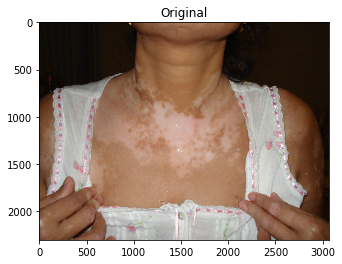

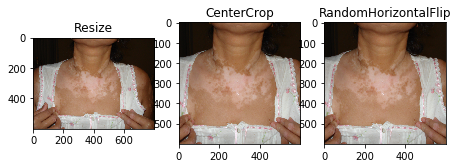

time: 3.3 s


In [13]:
# Code to visualize images and decide if the transforms are suitable

import matplotlib.pyplot as plt
from torchvision import models,transforms

lesions = Derm(train)
image, label = next(iter(lesions))

# Plot the original image
fig = plt.figure()
plt.imshow(image)
plt.title('Original')

# Transformations
resize = transforms.Resize(600)
crop = transforms.CenterCrop((600,600))
flip = transforms.RandomHorizontalFlip()

# Plot the image after the transformations
f = plt.figure(figsize=(10,10))
for i,tsfrm in enumerate([resize,crop,flip]):
  image = tsfrm(image)
  ax = f.add_subplot(1, 4, i + 1)
  ax.set_title(type(tsfrm).__name__)
  plt.imshow(image)

## Normalize

In [14]:
# ImageNet statistics
# Since we will be using a network previously trained on ImageNet images
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

# Define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize(600),
                                      transforms.CenterCrop((600,600)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

# Define the transformation of the validation images.
val_transform = transforms.Compose([transforms.Resize(600),
                                      transforms.CenterCrop((600,600)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

# Define the training and validation sets
train_set = Derm(train, transform=train_transform)
val_set = Derm(val, transform=val_transform)
test_set = Derm(test, transform=val_transform)


train_loader = DataLoader(train_set, batch_size=4,shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=4,shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=4,shuffle=True, num_workers=2)

classes=('not_skin','skin')

time: 23.3 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


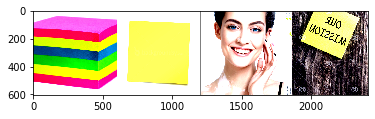

not_skin not_skin  skin not_skin
time: 6.1 s


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Transfer learning

In [16]:
from efficientnet_pytorch import EfficientNet

# Loading the pretrained model
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10) # 10 is the last layer of the convolutional base

# Freeze(False) or unfreeze the model weights
for param in model.parameters():
   param.requires_grad = True

Downloading: "https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
time: 5.45 s


## Define the CNN

In [17]:
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, Conv2d
from efficientnet_pytorch import EfficientNet

# Model to be used for training
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = model
        self.fc1 = nn.Linear(10, 2)
        # 10 comes from the last layer of the convolutional base
        # 2 comes from the number of classes we have: skin vs not skin
        
    def forward(self, x):
        x = self.model(x)
        x = self.fc1(x)
        return x

net = Net()
print(net)

Net(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_co

In [18]:
# Get total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

4,020,380 total parameters.
4,020,380 training parameters.
time: 6.18 ms


## Define a loss function and an optimizer

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

time: 2.99 ms


## Test the forward pass with dummy data

In [20]:
# First know how every image looks like
images.shape

torch.Size([4, 3, 600, 600])

time: 4.88 ms


In [21]:
# Test the forward pass with dummy data with some random input
input = torch.randn(4, 3, 600, 600)
out = net(input)
print(out.size())
print(out)

torch.Size([4, 2])
tensor([[-0.0876,  0.2429],
        [-0.1781,  0.2167],
        [-0.1077,  0.2503],
        [-0.1006,  0.1832]], grad_fn=<AddmmBackward>)
time: 4.03 s


## Training

In [22]:
import time
since = time.time() # To time the training loop

for epoch in range(1):  # loop over the dataset multiple times (in this case 1 time)

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Loss + Backward + Optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2 == 1:    # print every pair mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2))
            running_loss = 0.0

print('Finished Training')

# To time the script
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

[1,     2] loss: 0.653
[1,     4] loss: 0.621
[1,     6] loss: 0.754
[1,     8] loss: 0.740
[1,    10] loss: 0.708
[1,    12] loss: 0.742
[1,    14] loss: 0.726
[1,    16] loss: 0.747
[1,    18] loss: 0.699
[1,    20] loss: 0.644
[1,    22] loss: 0.638
[1,    24] loss: 0.722
[1,    26] loss: 0.696
[1,    28] loss: 0.683
[1,    30] loss: 0.725
[1,    32] loss: 0.753
[1,    34] loss: 0.664
[1,    36] loss: 0.637
[1,    38] loss: 0.580
[1,    40] loss: 0.604
[1,    42] loss: 0.760
[1,    44] loss: 0.611
[1,    46] loss: 0.758
[1,    48] loss: 0.653
[1,    50] loss: 0.653
[1,    52] loss: 0.580
[1,    54] loss: 0.584
[1,    56] loss: 0.585
[1,    58] loss: 0.578
[1,    60] loss: 0.604
[1,    62] loss: 0.540
[1,    64] loss: 0.505
[1,    66] loss: 0.534
[1,    68] loss: 0.678
[1,    70] loss: 0.518
Finished Training
Training complete in 9m 52s
time: 9min 52s


In [23]:
# Save the trained model
PATH = './test_net.pth'
torch.save(net.state_dict(), PATH)

time: 1.15 s


### Validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


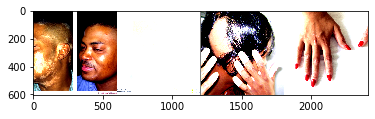

GroundTruth:   skin not_skin  skin  skin
time: 1.22 s


In [31]:
# First let's show some images from the validation set
dataiter = iter(val_loader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [32]:
# Load our saved network
net = Net()
net.load_state_dict(torch.load(PATH))

# Let's see what our network thinks those images are
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   skin not_skin  skin  skin
time: 4.69 s


In [35]:
# Performance on the whole validation set
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 18 val images: %d %%' % (
    100 * correct / total))

#Randomly picking a class out of 2 classes would be 50% accuracy.

Accuracy of the network on the 18 val images: 94 %
time: 14.1 s


In [36]:
# What are the classes that performed well, and the classes that did not perform well:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(2):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of not_skin : 66 %
Accuracy of  skin : 100 %
time: 13.6 s


## Test

In [37]:
# Performance on the whole test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 18 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 18 test images: 95 %
time: 14.4 s


## Conclusion
We have better results finetunning EfficientNet rather than using EfficientNet as a feature extractor.
Although accuracy is not the best measurement because of the unbalanced classes.